<font size="+2">Training a Street Situation Detection Network</font>


This project deals with the problem of detecting street situation images (images which are taken on the outside). The used dataset for training the network, was self-created. In order to get a copy of the dataset, contact s0558366@htw-berlin.de

# Requirements

## Imports

In [1]:
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
print('TensorFlow version: {}'.format(tf.__version__))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TensorFlow version: 2.1.0
TensorFlow version: 2.1.0
TensorFlow version: 2.1.0


## Model configuration

In [2]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 16

In [3]:
CLASSES = ["no street", "street"]

In [4]:
log_dir = "./logs"

# Data

In [5]:
data_path = "./evaluation-images"
data_path = pathlib.Path(data_path)

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

data_gen = data_gen.flow_from_directory(directory=str(data_path),
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 37 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


In [6]:
images = []
labels = []
batch_index = 0
while batch_index <= data_gen.batch_index:
    data = data_gen.next()
    if len(images) == 0:
        images = data[0]
        labels = data[1]
    else:
        images = np.append(images, data[0], axis=0)
        labels = np.append(labels, data[1], axis=0)
    
    batch_index = batch_index + 1

## Load best model

In [7]:
all_model_dirs = [os.path.join(log_dir, d) for d in os.listdir(log_dir) if "model" in d]
latest_model_dir = max(all_model_dirs, key=os.path.getmtime)
best_model = keras.models.load_model(latest_model_dir)

## Loss and accuracy

In [8]:
loss, acc = best_model.evaluate(data_gen)
print('\nTestloss: {} and accuracy: {}'.format(loss, acc))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
3/3 [==============================] - 4s 1s/step - loss: 0.6128 - accuracy: 0.9189

Testloss: 0.6128129763916755 and accuracy: 0.9189189076423645

Testloss: 0.6128129763916755 and accuracy: 0.9189189076423645

Testloss: 0.6128129763916755 and accuracy: 0.9189189076423645


## Confusion matrix

In [9]:
def create_confusion_matrix(labels, predictions, class_name=None):
    if not class_name:
        class_name = list(set(labels))
        
    con_mat = tf.math.confusion_matrix(labels=labels, 
                                       predictions=predictions).numpy()
    con_mat_df = pd.DataFrame(con_mat,
                         index = class_name, 
                         columns = class_name)

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

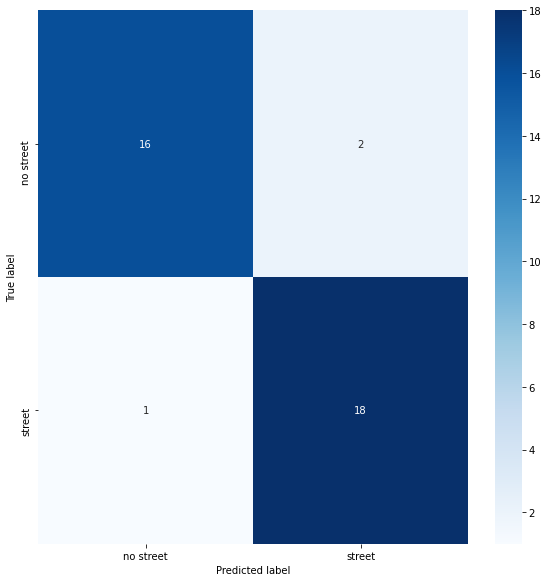

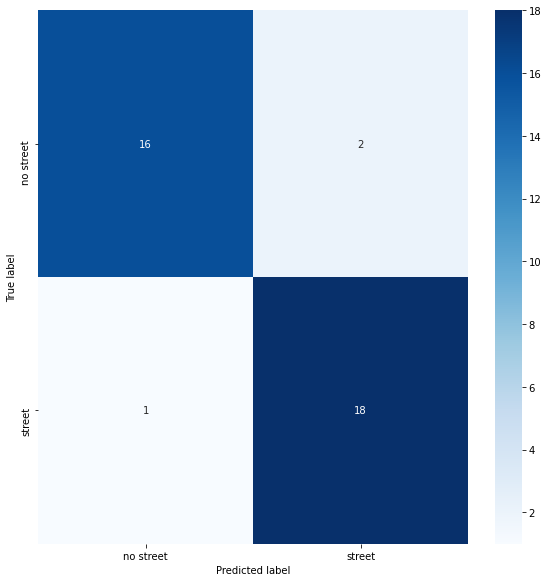

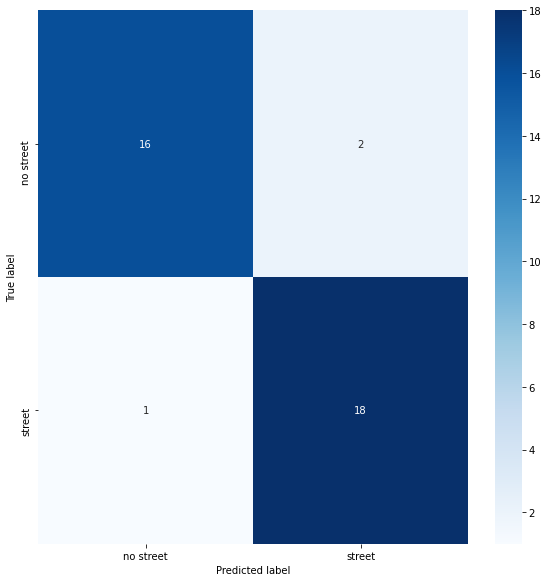

In [10]:
y_pred = best_model.predict(images)
y_pred = np.argmax(y_pred, axis=1)
create_confusion_matrix(data_gen.classes, y_pred, CLASSES)

## Generate Heatmap

In [11]:
def generate_heatmap(model, image):
    image = np.expand_dims(image, axis=0)
    
    conv_layer = best_model.get_layer("conv5_block3_2_conv")
    heatmap_model = tf.keras.models.Model([best_model.inputs], [conv_layer.output, best_model.output])
    
    # Get gradient of the winner class w.r.t. the output of the (last) conv. layer
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(image)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = np.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return heatmap

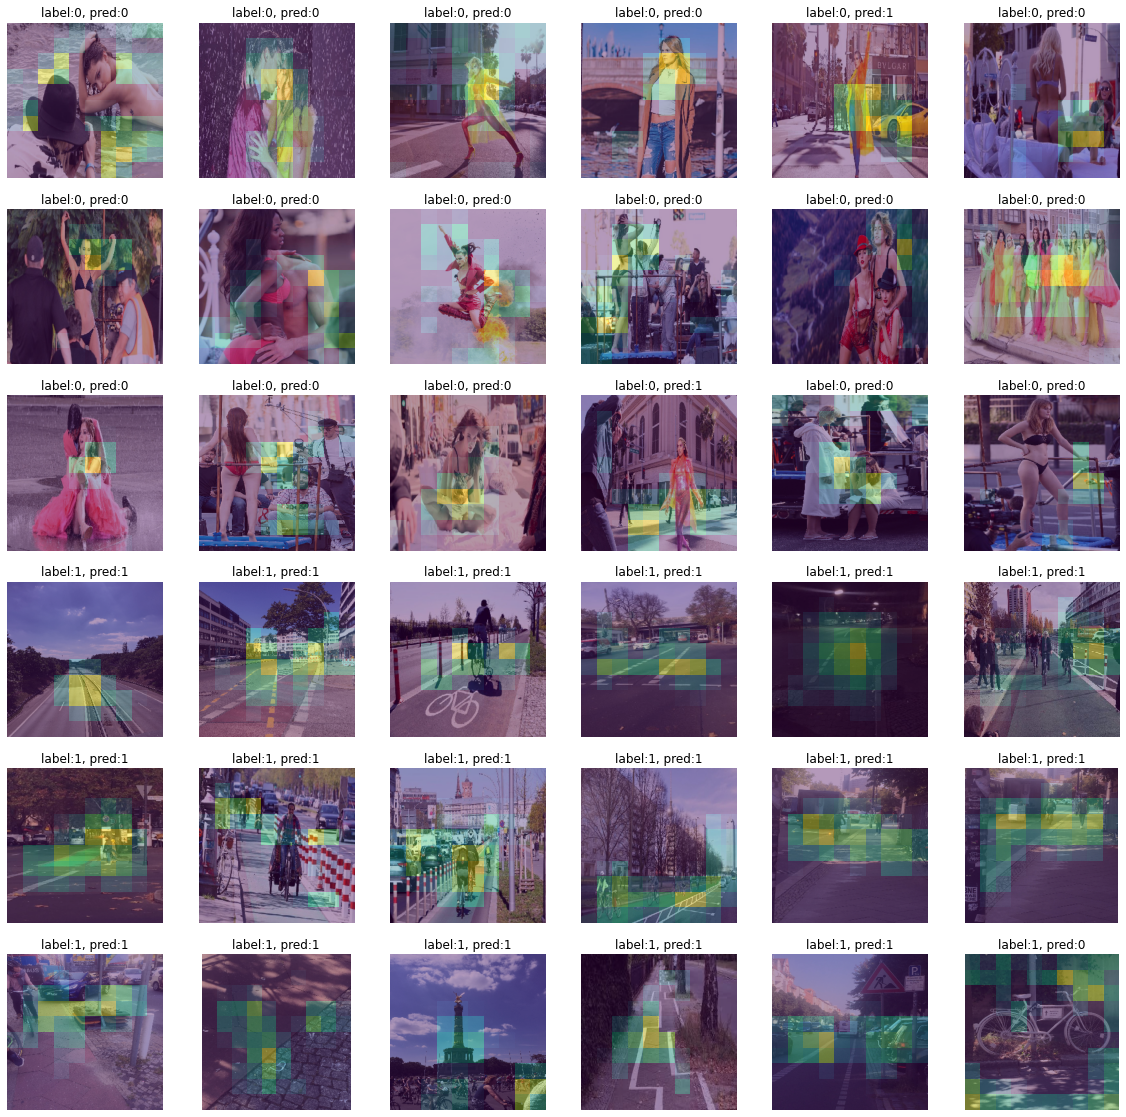

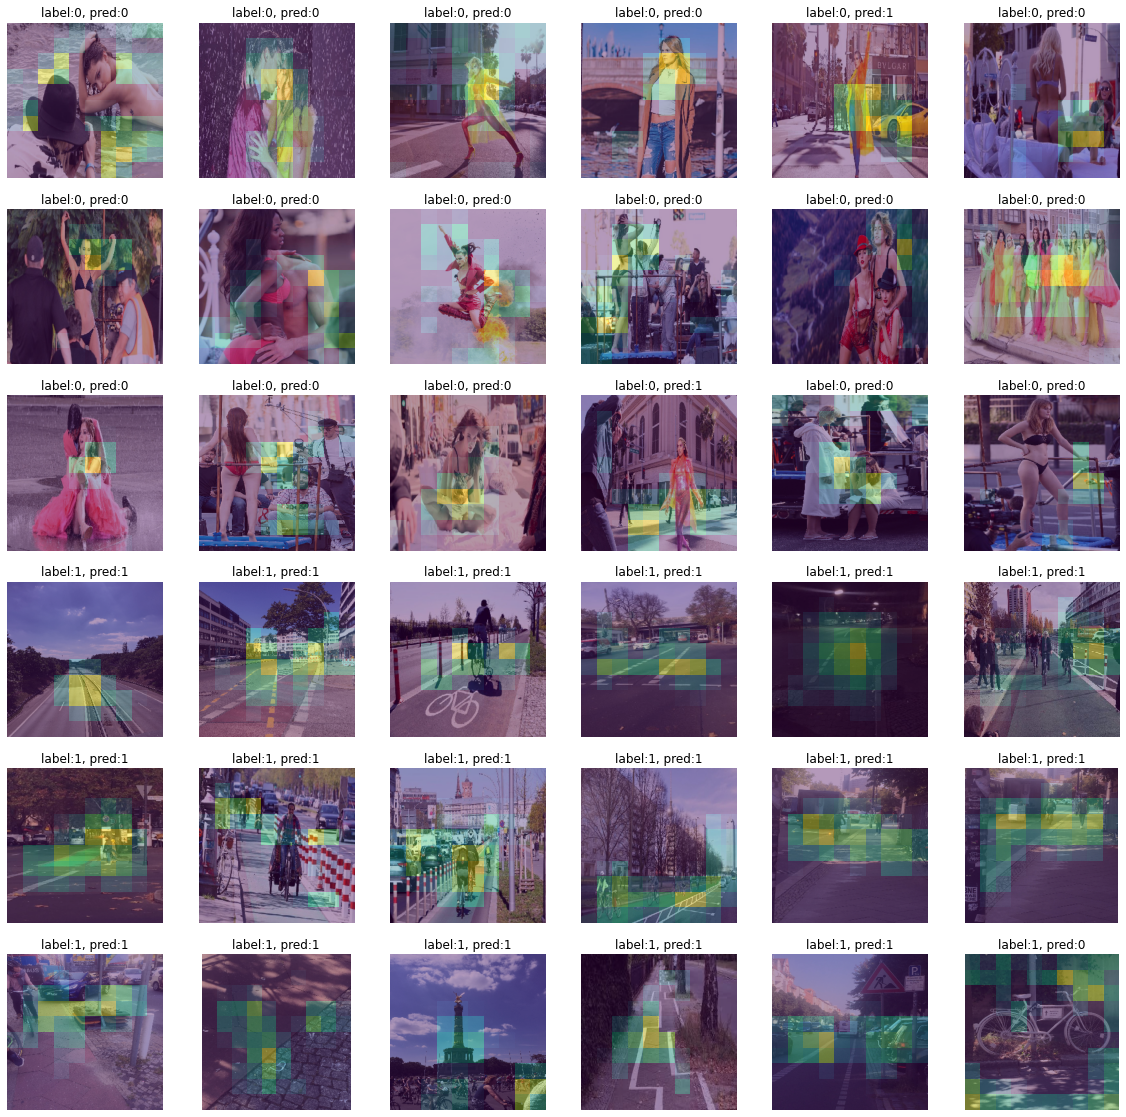

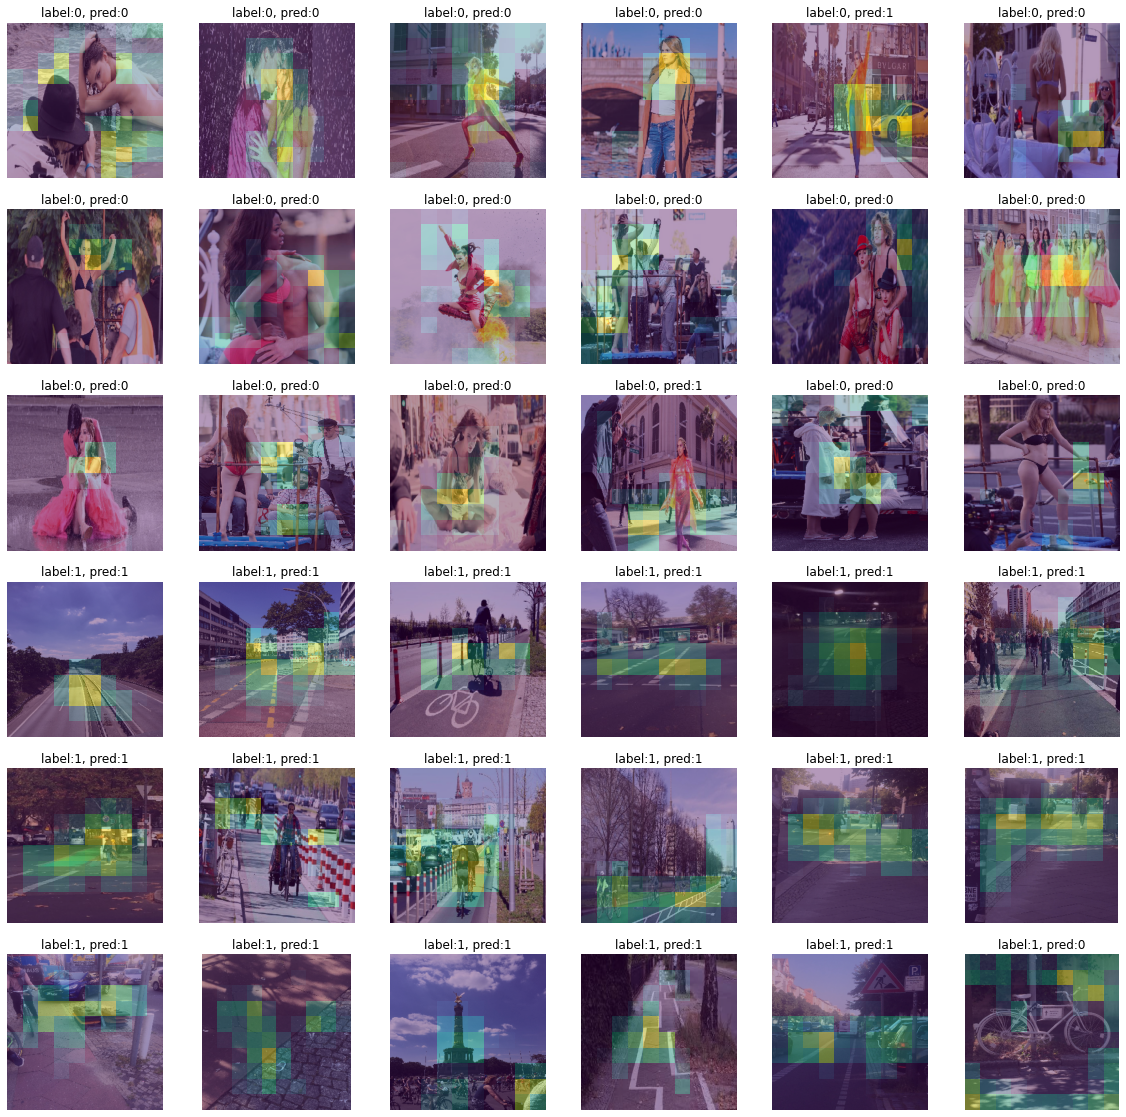

In [12]:
plt.figure(figsize=(20, 20))
for n in range(36):
    ax = plt.subplot(6,6,n+1)
    
    image = images[n]
    label = np.argmax(labels[n])
    pred = y_pred[n]

    heatmaps = generate_heatmap(best_model, image)
    extent = np.min(image), np.max(image), np.min(heatmaps[0]), np.max(heatmaps[0])
    
    plt.title("label:{}, pred:{}".format(label, pred))
    plt.imshow(image, extent=extent)
    plt.imshow(heatmaps[0], alpha=0.4, extent=extent)
    plt.axis('off')